In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

import glob, os, random, zipfile
import tensorflow as tf

In [5]:
dataset_path = '/content/gdrive/MyDrive/dataset-pa'
zip_file = zipfile.ZipFile('/content/gdrive/MyDrive/dataset-pa/pakaian-adat-baru.zip')
zip_file.extractall(dataset_path)
zip_file.close()

In [6]:
base_path = os.path.join(dataset_path, '/content/gdrive/MyDrive/dataset-pa/pakaian-adat-baru')

# img_list  = glob.glob(os.path.join(base_path, '*/*.jpg' + '*/*.jpeg'))
# print(len(img_list))

from os.path import join
from glob import glob

img_list = []
for ext in ('*/*.jpg', '*/*.jpeg', '*/*.png'):
   img_list.extend(glob(join(base_path, ext)))

print(len(img_list))

1050


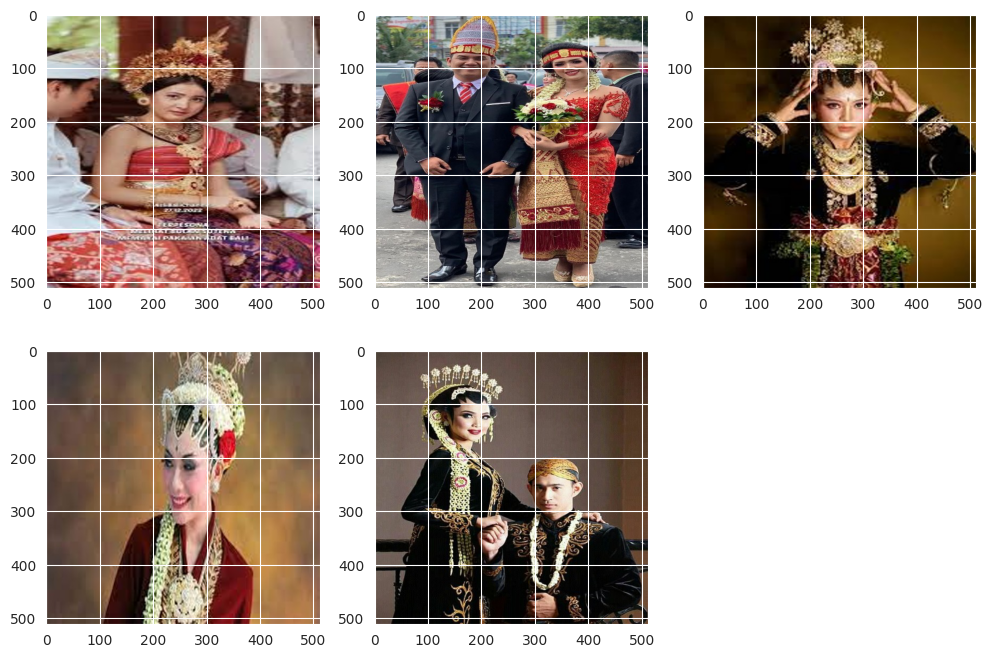

In [26]:
plt.figure(figsize=(12, 8))
for i, img_path in enumerate(random.sample(img_list, 5)):
    if not os.path.exists(img_path):
        continue

    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [36]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.3
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = train_datagen.flow_from_directory(
     base_path,
     target_size=(224, 224),
     batch_size=8,
     class_mode='categorical',
     subset='validation',
     seed=0
)

test_generator = test_datagen.flow_from_directory(
     base_path,
     target_size=(224, 224),
     batch_size=8,
     class_mode='categorical',
     subset='validation',
     seed=0
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

Found 735 images belonging to 7 classes.
Found 315 images belonging to 7 classes.
Found 105 images belonging to 7 classes.
{0: 'PA-Bali', 1: 'PA-Kalbar', 2: 'PA-Papua', 3: 'PA-Riau', 4: 'PA-Sulsel', 5: 'PA-Sumut', 6: 'Pa-Jateng'}


# Training Model

In [9]:
mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(224 , 224, 3),
                                           include_top=False,
                                           weights='imagenet')

def make_model():
    model = Sequential()
    model.add(mobilenet)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1024, activation="relu"))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(256, activation="relu"))
    model.add(Dense(7, activation="softmax" , name="classification"))

    return model

model = make_model() 

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

model.summary()           

17225924/17225924 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                         

In [10]:
history = model.fit(train_generator, epochs=30, validation_data=validation_generator)

Epoch 1/30
92/92 [==============================] - 42s 279ms/step - loss: 1.7216 - accuracy: 0.3061 - val_loss: 1.4530 - val_accuracy: 0.4635
Epoch 2/30
92/92 [==============================] - 19s 212ms/step - loss: 1.0665 - accuracy: 0.6054 - val_loss: 1.1898 - val_accuracy: 0.5587
Epoch 3/30
92/92 [==============================] - 21s 224ms/step - loss: 0.7859 - accuracy: 0.7143 - val_loss: 0.9864 - val_accuracy: 0.6667
Epoch 4/30
92/92 [==============================] - 19s 210ms/step - loss: 0.6402 - accuracy: 0.7905 - val_loss: 0.7943 - val_accuracy: 0.7206
Epoch 5/30
92/92 [==============================] - 21s 225ms/step - loss: 0.4734 - accuracy: 0.8272 - val_loss: 0.7413 - val_accuracy: 0.7714
Epoch 6/30
92/92 [==============================] - 19s 212ms/step - loss: 0.4868 - accuracy: 0.8422 - val_loss: 0.8675 - val_accuracy: 0.7365
Epoch 7/30
92/92 [==============================] - 21s 227ms/step - loss: 0.3608 - accuracy: 0.8612 - val_loss: 0.8081 - val_accuracy: 0.7397

# Visualizing loss curves

40/40 [==============================] - 5s 128ms/step - loss: 0.6139 - accuracy: 0.8222


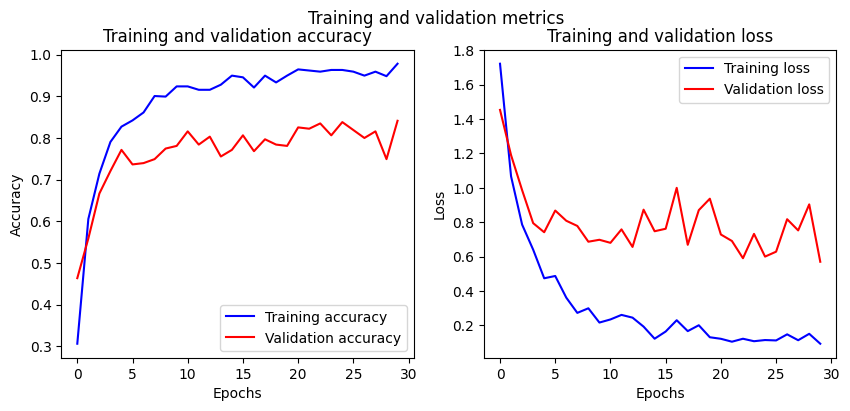

In [12]:
model.evaluate(validation_generator)

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=12)
plt.show()

1/1 [==============================] - 0s 464ms/step


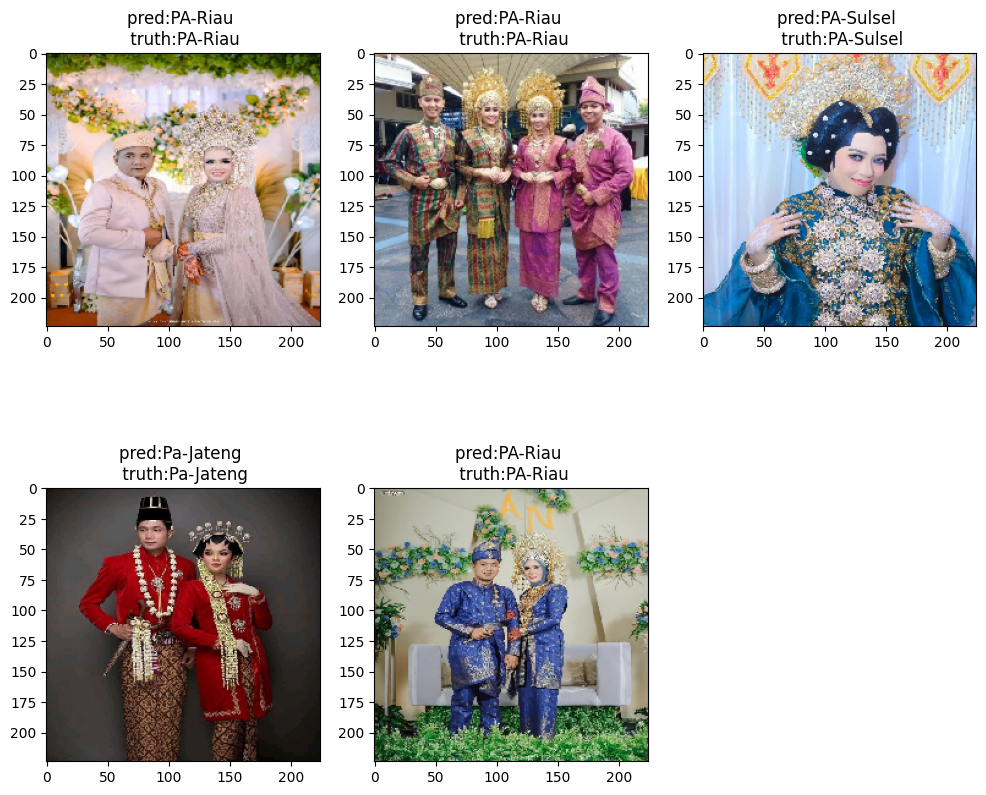

In [13]:
test_x, test_y = test_generator.__getitem__(1)

preds = model.predict(test_x)

plt.figure(figsize=(12, 16))
for i in range(5):
  plt.subplot(3, 3, i+1)
  plt.title('pred:%s \n truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
  plt.imshow(test_x[i])

In [38]:
NUM_CLASSES = 7
pakaianadat_classes = ["PA-Bali", "PA-Jakarta", "PA-Jateng", "PA-Kalbar" 
                   "PA-Papua", "PA-Riau", "PA-Sulsel","PA-Sumut"]


In [16]:
model.save_weights("model_pakaian_adat_indonesia.h5")